In [1]:
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

from binance import Client

client = Client()

In [2]:
# global config
symbol = "BTCUSDT"
interval = client.KLINE_INTERVAL_1HOUR
data_lim = 6 * 30 * 24 # 1 hour in 6 months
# start = int(time.time() - data_lim * 3600)

start = int((datetime.today() - timedelta(days=30)).timestamp()*1000)

In [6]:
# dataframe use for saving data

cols = ["openTime", "open", "high", "low", "close",
        "volume", "closeTime", "quoteAssetVolume", "numberOfTrader",
        "takerBuyBaseAssetVolume", "takerBuyQuoteAssetVolume", "ignore"]
df = pd.DataFrame(columns=cols)

In [7]:
klines = client.get_klines(symbol=symbol, interval=interval, startTime=start, limit=1000)

In [8]:
klines

[[1682053200000,
  '28236.15000000',
  '28257.70000000',
  '28154.73000000',
  '28158.21000000',
  '1526.07043000',
  1682056799999,
  '43066368.30933460',
  30135,
  '661.09803000',
  '18658071.57580150',
  '0'],
 [1682056800000,
  '28158.22000000',
  '28216.10000000',
  '27815.89000000',
  '27916.88000000',
  '6833.12140000',
  1682060399999,
  '191373515.54282220',
  103198,
  '3072.34750000',
  '86048580.87132820',
  '0'],
 [1682060400000,
  '27916.87000000',
  '28173.94000000',
  '27839.31000000',
  '28155.03000000',
  '5443.96189000',
  1682063999999,
  '152355493.13394260',
  89015,
  '3122.80075000',
  '87403055.52622060',
  '0'],
 [1682064000000,
  '28155.02000000',
  '28237.30000000',
  '28015.71000000',
  '28071.90000000',
  '2847.93515000',
  1682067599999,
  '80064735.18189570',
  57792,
  '1389.19303000',
  '39057693.08022460',
  '0'],
 [1682067600000,
  '28071.89000000',
  '28112.50000000',
  '27967.09000000',
  '28060.85000000',
  '1945.42052000',
  1682071199999,
  '54

In [9]:
for kline in klines:
    df.loc[len(df)] = kline

# df = pd.read_csv("BTC_USDT.csv")

In [15]:
df = df.sort_values(by="closeTime", ascending=True)
df

,openTime,open,high,low,close,volume,closeTime,quoteAssetVolume,numberOfTrader,takerBuyBaseAssetVolume,takerBuyQuoteAssetVolume,ignore
0,1682053200000,28236.15000000,28257.70000000,28154.73000000,28158.21000000,1526.07043000,1682056799999,43066368.30933460,30135,661.09803000,18658071.57580150,0
1,1682056800000,28158.22000000,28216.10000000,27815.89000000,27916.88000000,6833.12140000,1682060399999,191373515.54282220,103198,3072.34750000,86048580.87132820,0
2,1682060400000,27916.87000000,28173.94000000,27839.31000000,28155.03000000,5443.96189000,1682063999999,152355493.13394260,89015,3122.80075000,87403055.52622060,0
3,1682064000000,28155.02000000,28237.30000000,28015.71000000,28071.90000000,2847.93515000,1682067599999,80064735.18189570,57792,1389.19303000,39057693.08022460,0
4,1682067600000,28071.89000000,28112.50000000,27967.09000000,28060.85000000,1945.42052000,1682071199999,54560381.19529480,37520,851.81226000,23889305.67887860,0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1683835200000,26843.06000000,27037.61000000,26807.22000000,26996.18000000,1419.53922000,1683838799999,38207418.41144110,42131,777.59187000,20931894.16168750,0
496,1683838800000,26996.17000000,27060.47000000,26941.51000000,26977.99000000,821.53189000,1683842399999,22187981.77762240,31661,426.12913000,11508893.95785600,0
497,1683842400000,26978.00000000,27056.44000000,26900.00000000,26903.81000000,1043.33136000,1683845999999,28145264.28037720,33852,464.01731000,12518977.76053580,0
498,1683846000000,26903.80000000,27056.18000000,26820.00000000,26968.62000000,1444.38656000,1683849599999,38910622.88691130,42328,702.36669000,18922759.74519220,0


In [17]:
df = df[["close", "high", "low", "open", "volume", "quoteAssetVolume", "numberOfTrader", \
                   "takerBuyBaseAssetVolume", "takerBuyQuoteAssetVolume"]]
df

,close,high,low,open,volume,quoteAssetVolume,numberOfTrader,takerBuyBaseAssetVolume,takerBuyQuoteAssetVolume
0,28158.21000000,28257.70000000,28154.73000000,28236.15000000,1526.07043000,43066368.30933460,30135,661.09803000,18658071.57580150
1,27916.88000000,28216.10000000,27815.89000000,28158.22000000,6833.12140000,191373515.54282220,103198,3072.34750000,86048580.87132820
2,28155.03000000,28173.94000000,27839.31000000,27916.87000000,5443.96189000,152355493.13394260,89015,3122.80075000,87403055.52622060
3,28071.90000000,28237.30000000,28015.71000000,28155.02000000,2847.93515000,80064735.18189570,57792,1389.19303000,39057693.08022460
4,28060.85000000,28112.50000000,27967.09000000,28071.89000000,1945.42052000,54560381.19529480,37520,851.81226000,23889305.67887860
...,...,...,...,...,...,...,...,...,...
495,26996.18000000,27037.61000000,26807.22000000,26843.06000000,1419.53922000,38207418.41144110,42131,777.59187000,20931894.16168750
496,26977.99000000,27060.47000000,26941.51000000,26996.17000000,821.53189000,22187981.77762240,31661,426.12913000,11508893.95785600
497,26903.81000000,27056.44000000,26900.00000000,26978.00000000,1043.33136000,28145264.28037720,33852,464.01731000,12518977.76053580
498,26968.62000000,27056.18000000,26820.00000000,26903.80000000,1444.38656000,38910622.88691130,42328,702.36669000,18922759.74519220


In [18]:
df["label"] = df.close.shift(-1)
X_last = df.iloc[-1, :-1].values
df = df.dropna()
df

,close,high,low,open,volume,quoteAssetVolume,numberOfTrader,takerBuyBaseAssetVolume,takerBuyQuoteAssetVolume,label
0,28158.21000000,28257.70000000,28154.73000000,28236.15000000,1526.07043000,43066368.30933460,30135,661.09803000,18658071.57580150,27916.88000000
1,27916.88000000,28216.10000000,27815.89000000,28158.22000000,6833.12140000,191373515.54282220,103198,3072.34750000,86048580.87132820,28155.03000000
2,28155.03000000,28173.94000000,27839.31000000,27916.87000000,5443.96189000,152355493.13394260,89015,3122.80075000,87403055.52622060,28071.90000000
3,28071.90000000,28237.30000000,28015.71000000,28155.02000000,2847.93515000,80064735.18189570,57792,1389.19303000,39057693.08022460,28060.85000000
4,28060.85000000,28112.50000000,27967.09000000,28071.89000000,1945.42052000,54560381.19529480,37520,851.81226000,23889305.67887860,28001.96000000
...,...,...,...,...,...,...,...,...,...,...
494,26843.05000000,27055.00000000,26702.05000000,26963.74000000,2471.46579000,66422258.38650220,66600,1195.17560000,32125179.63722650,26996.18000000
495,26996.18000000,27037.61000000,26807.22000000,26843.06000000,1419.53922000,38207418.41144110,42131,777.59187000,20931894.16168750,26977.99000000
496,26977.99000000,27060.47000000,26941.51000000,26996.17000000,821.53189000,22187981.77762240,31661,426.12913000,11508893.95785600,26903.81000000
497,26903.81000000,27056.44000000,26900.00000000,26978.00000000,1043.33136000,28145264.28037720,33852,464.01731000,12518977.76053580,26968.62000000


# normalize data

In [19]:
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()
X_prepared = scalerX.fit_transform(df.drop(columns="label"))
y_prepared = scalerY.fit_transform(df.label.values.reshape(-1, 1))

# split train test

In [20]:
train_idxs = X_prepared.shape[0] - CFG.n_predicts
X_train, X_test = X_prepared[:train_idxs, :], X_prepared[train_idxs:, :]
y_train, y_test = y_prepared[:train_idxs, :], y_prepared[train_idxs:, :]

X_train.shape, X_test.shape

((451, 9), (48, 9))

In [21]:
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)

X_train.shape, X_test.shape

((451, 1, 9), (48, 1, 9))

# Keras model

In [22]:
units = 64
n_hours = 1
n_time_predicts = 2 * 24
epochs = 50
batch_size = 128
verbose = 0
min_delta = 1e-15
patience = 30
monitor = 'val_loss'

In [23]:
model = Sequential()
model.add(LSTM(units,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# model training

In [24]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False, validation_data=(X_test, y_test),
    callbacks = [EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience)])

In [25]:
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

2/2 [==============================] - 0s 3ms/step


Text(0, 0.5, 'USD ($)')

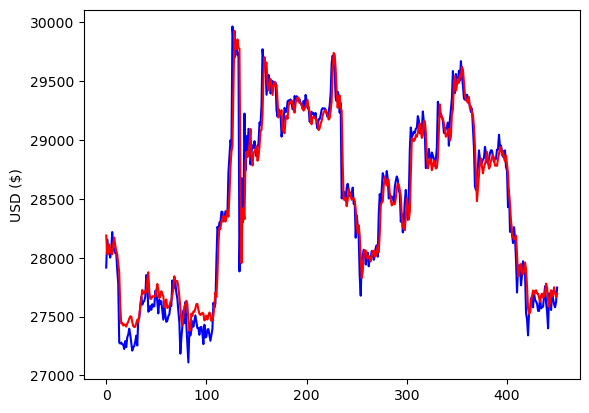

In [26]:
# training fig
y_train_back = scalerY.inverse_transform(y_train)
y_train_hat_back = scalerY.inverse_transform(y_train_hat)

plt.plot(y_train_back, c='b', label="test",)
plt.plot(y_train_hat_back, c='r', label="predict")

plt.ylabel("USD ($)")

Text(0, 0.5, 'USD ($)')

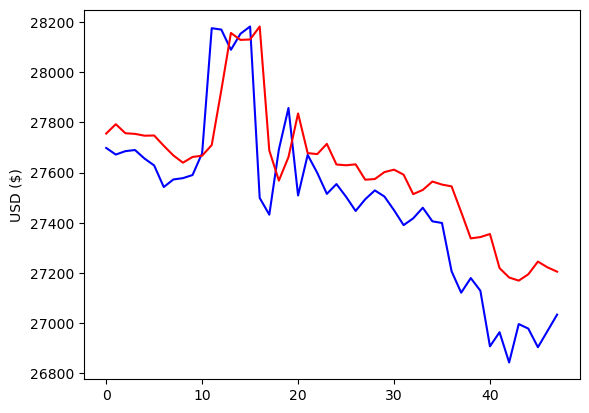

In [27]:
# testing fig
y_test_back = scalerY.inverse_transform(y_test)
y_test_hat_back = scalerY.inverse_transform(y_test_hat)

plt.plot(y_test_back, c='b', label="test",)
plt.plot(y_test_hat_back, c='r', label="predict")

plt.ylabel("USD ($)")

In [28]:
X_test.shape

(48, 1, 9)

In [29]:
X_last_prepared = scalerX.transform(X_last.reshape(1, -1))
X_last_prepared = np.expand_dims(X_last_prepared, 1)

C:\Users\mirom\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [30]:
y_last = model.predict(X_last_prepared)
y_last_back = scalerY.inverse_transform(y_last)


1/1 [==============================] - 0s 18ms/step


In [31]:
y_test_hat_df = pd.DataFrame(y_test_hat_back).reset_index()
y_test_hat_df.index = y_test_hat_df.index.astype("int")
y_test_hat_plot = y_test_hat_df.values.tolist()

y_last_plot = [y_test_hat_plot[-1]]
y_last_plot.append([len(y_test_hat_plot), y_last_back.item()])

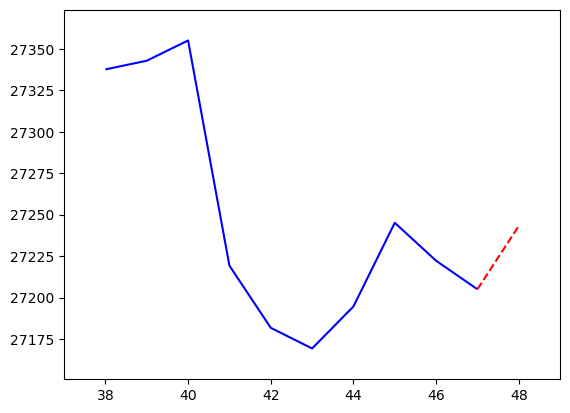

In [32]:
import pylab as pl
from matplotlib import collections  as mc

lines = [y_test_hat_plot[-10:], y_last_plot]

lc = mc.LineCollection(lines, colors=['b', 'r'], linestyle=['-', '--'])
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

# export json

In [33]:
y_last_back.item()

27243.17578125

In [34]:
data = {
    "openPrice": df.close.values[-1],
    "predictPrice": round(y_last_back.item(), 2)
  }

In [35]:
import json
with open('../src/components/predict_1hour.json', 'w') as f:
    json.dump(data, f)

In [36]:
round(y_last_back.item(), 2)

27243.18